# Word2Vec

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip3 install -r stepik-dl-nlp/requirements.txt

import sys; 
sys.path.append('./stepik-dl-nlp')

In [2]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import gensim

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [4]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [5]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [6]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 649 648
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


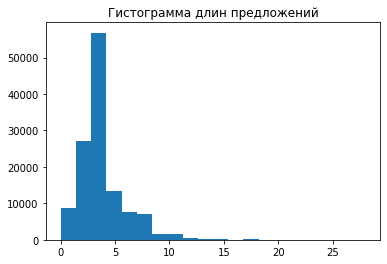

In [7]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [8]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [9]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [10]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе
device

device(type='cuda', index=0)

In [12]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 150, MAX_SENTENCE_LEN,
                                          radius=3, negative_samples_n=50)

In [13]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-1,
                                            epoch_n=100,
                                            batch_size=2048,
                                            device=device,
                                            early_stopping_patience=5,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))
print()
print(f"Лучшее значении функции потерь: {best_val_loss}")

Эпоха 0
Эпоха: 62 итераций, 2.34 сек
Среднее значение функции потерь на обучении 0.7744375986437644
Среднее значение функции потерь на валидации 0.7628631724251641
Новая лучшая модель!

Эпоха 1
Эпоха: 62 итераций, 2.44 сек
Среднее значение функции потерь на обучении 0.7620077681156897
Среднее значение функции потерь на валидации 0.7632620400852628

Эпоха 2
Эпоха: 62 итераций, 2.40 сек
Среднее значение функции потерь на обучении 0.7618279264819238
Среднее значение функции потерь на валидации 0.7643150047019676
Epoch     3: reducing learning rate of group 0 to 1.0000e-02.

Эпоха 3
Эпоха: 62 итераций, 2.30 сек
Среднее значение функции потерь на обучении 0.7572505416408661
Среднее значение функции потерь на валидации 0.7598744410055654
Новая лучшая модель!

Эпоха 4
Эпоха: 62 итераций, 2.26 сек
Среднее значение функции потерь на обучении 0.7548265216812011
Среднее значение функции потерь на валидации 0.759309830488982
Новая лучшая модель!

Эпоха 5
Эпоха: 62 итераций, 2.47 сек
Среднее значен

In [14]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), './stepik-dl-nlp/models/sgns.pth')

In [15]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('./stepik-dl-nlp/models/sgns.pth'))

<All keys matched successfully>

За счет уменьшения окна и переноса на видеокарту получилось заметно ускорить обучение и уменьшить итоговую функцию потерь на 15 пунктов. Так же увеличение lr помогла побыстрее добиться того, что все сойдется.   
  
Изменение негативных семплов вообще ни к чему не приводит, похоже они слишком мало вносят в функцию потерь.

Значительно ускорить обучение удалось переносом на видокарту вычисления и увеличением батча, а увеличение

## Исследуем характеристики полученных векторов

In [16]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [17]:
embeddings.most_similar('chicken')

[('chicken', 0.9999486),
 ('stock', 0.54115427),
 ('turkey', 0.5336048),
 ('thighs', 0.52135575),
 ('duck', 0.52088296),
 ('beef', 0.5170144),
 ('veal', 0.4893977),
 ('breasts', 0.48416445),
 ('broth', 0.45646566),
 ('wings', 0.45419812)]

In [18]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('cacao', 1.1575216),
 ('cheese', 0.95400655),
 ('cheeses', 0.7084588),
 ('semi', 0.69504964),
 ('pecorino', 0.65737563),
 ('monterey', 0.65174496),
 ('solids', 0.65051293),
 ('elbow', 0.6291064),
 ('jack', 0.61748767),
 ('percent', 0.6137212)]

In [19]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 150)


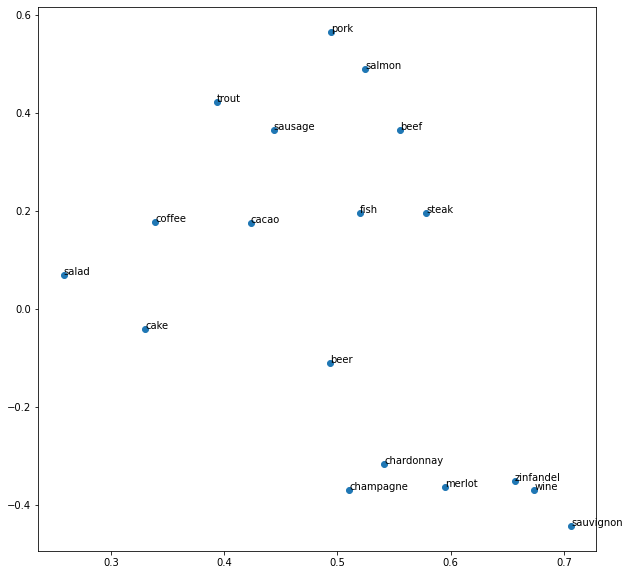

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec и FastText с помощью Gensim

In [21]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

w2v_most_similar_func = word2vec.wv.most_similar#('chicken')

gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
w2v_gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

In [22]:
fasttext = gensim.models.FastText(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

fasttext_most_similar_func = fasttext.wv.most_similar#('chicken')

gensim_words = [w for w in test_words if w in fasttext.wv.vocab]
ft_gensim_vectors = np.stack([fasttext.wv[w] for w in gensim_words])

## Сравнение fasttext и word2vec

### Посмотрим списки похожих слов для нескольких примеров

In [23]:
print(f"Word2Vector - FastText")
print()
for word in ['chicken', 'steak', 'cheese']:
  print(f'Топ 5 ответов на слово {word}')
  w2v = w2v_most_similar_func(word)
  ft = fasttext_most_similar_func(word)
  for i in range(5):
    w2v_word, w2v_prob = w2v[i]
    ft_word, ft_prob = ft[i]
    print(f"{w2v_word}: {w2v_prob} - {ft_word}: {ft_prob}")
  print()

Word2Vector - FastText

Топ 5 ответов на слово chicken
duck: 0.7248526811599731 - chickens: 0.9078936576843262
simmering: 0.70777428150177 - chick: 0.8011717796325684
thighs: 0.7063819169998169 - duck: 0.7276973724365234
drumsticks: 0.6859389543533325 - drumstick: 0.717978835105896
pheasant: 0.6830736994743347 - turkey: 0.7056881189346313

Топ 5 ответов на слово steak
skirt: 0.9065098166465759 - steaks: 0.9035670757293701
flank: 0.9048833250999451 - stew: 0.8507398366928101
sirloin: 0.8968334197998047 - skirt: 0.8454320430755615
mignon: 0.8457694053649902 - sirloin: 0.8453919291496277
swordfish: 0.8438214659690857 - flank: 0.8306909799575806

Топ 5 ответов на слово cheese
salata: 0.7868016958236694 - cheeses: 0.9493225812911987
monterey: 0.7749799489974976 - salata: 0.8074695467948914
pecorino: 0.7586265802383423 - pecorino: 0.7838910818099976
gruyere: 0.7500640749931335 - feta: 0.7780879139900208
cheddar: 0.7459198236465454 - monterey: 0.7763758897781372



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Сравним получившиеся кластера на графике

Оранжевый цвет - модель FastText, синий - word2vec.


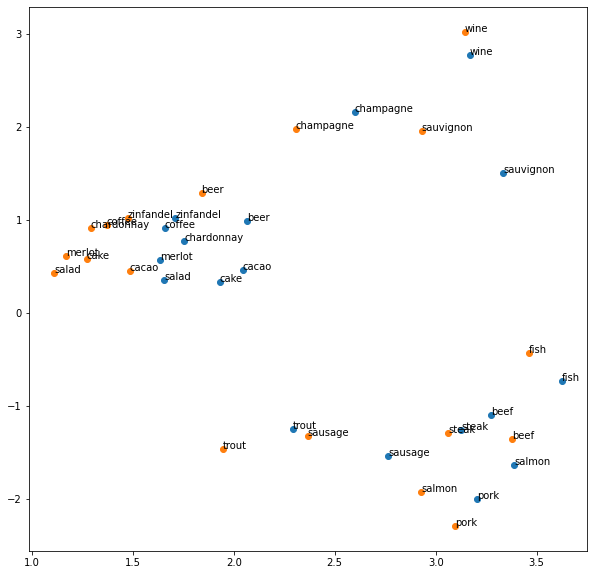

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(ft_gensim_vectors, test_words, how='svd', ax=ax)
plot_vectors(w2v_gensim_vectors, test_words, how='svd', ax=ax)
print('Оранжевый цвет - модель FastText, синий - word2vec.')

### В целом, оба метода векторизации дают примерно одинаковые наборы ответов. Однако можно заметить, что FastText отдает предпочтение более близким по написанию словам (что логично, учитывая, что он обучался на триграммах) и в целом более уверен в своих ответах. Однако на таком маленьком корпусе заметить что-то большее проблематично